In [13]:
! git clone https://github.com/jianxu305/nCov2019_analysis/

import sys
import os
os.chdir('/content/nCov2019_analysis/src')

sys.path.append('/content/nCov2019_analysis/src')

fatal: destination path 'nCov2019_analysis' already exists and is not an empty directory.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
import datetime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
data = utils.load_chinese_data()

Last update:  2020-02-28 17:43:38.486000
Data date range:  2020-01-24 to 2020-02-28
Number of rows in raw data:  58900


In [0]:
daily_frm = utils.aggDaily(data)

In [12]:
jhs_raw = utils.load_jhs_raw('2020-02-27')

AttributeError: ignored

In [7]:
jhs_frm.tail()

,province/state,country/region,cum_confirmed,Deaths,recovered,update_time,update_date
100,"Seattle, WA",US,1.0,0.0,1.0,2020-02-09 07:03:04,2020-02-09
101,"Tempe, AZ",US,1.0,0.0,1.0,2020-02-25 21:23:03,2020-02-25
102,"Lackland, TX (From Diamond Princess)",US,0.0,0.0,0.0,2020-02-24 23:33:02,2020-02-24
103,"Omaha, NE (From Diamond Princess)",US,0.0,0.0,0.0,2020-02-24 23:33:02,2020-02-24
104,"Travis, CA (From Diamond Princess)",US,0.0,0.0,0.0,2020-02-24 23:33:02,2020-02-24


## 1. Sanity Check
### 1.1 Take a Brief Look at the data

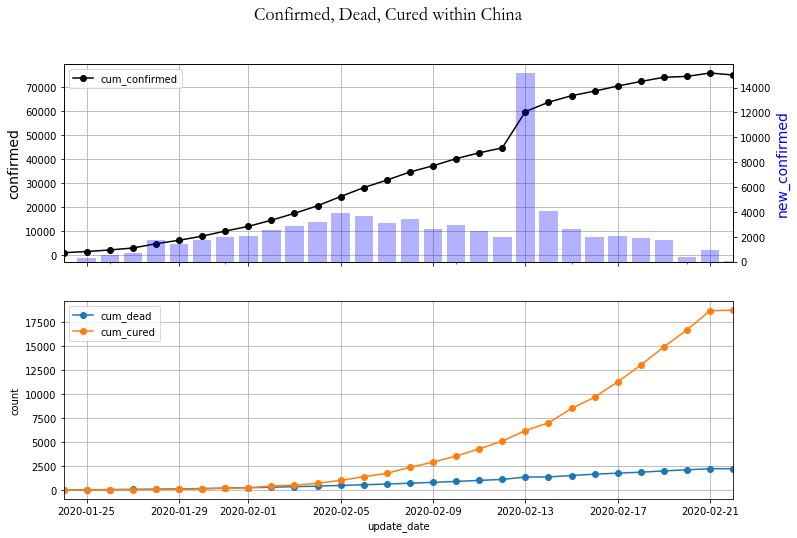

In [0]:
fig = utils.tsplot_conf_dead_cured(daily_frm, title='Confirmed, Dead, Cured within China', figsize=(12, 8))

### 1.2 Confirm the ~2% mortality rate

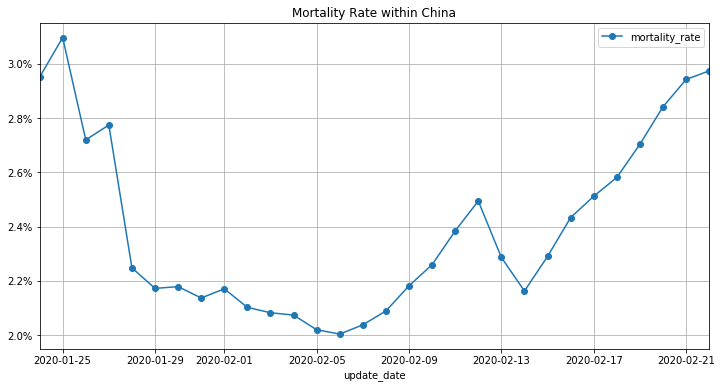

In [0]:
avg_frm = daily_frm.groupby('update_date').agg('sum')
avg_frm['mortality_rate'] = avg_frm['cum_dead'] / avg_frm['cum_confirmed']
ax = avg_frm.plot(y='mortality_rate', grid=True, figsize=(12, 6), marker='o', title='Mortality Rate within China')
plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

## 2. Mortality Rate Disparity

In [0]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
api_key  = ''  # use you own key
user_name = ''  # use your own user name
chart_studio.tools.set_credentials_file(username=user_name, api_key=api_key)

### Split the mortality rate into three regions:
Wuhan, Hubei Province except Wuhan, and China except Hubei Province

In [0]:
daily_frm['region'] = np.where(daily_frm['city_name_en'] == 'Wuhan', 'Wuhan', 
                  np.where(daily_frm['province_name_en'] == 'Hubei', 'Hubei_ex_Wuhan', 'China_ex_Hubei'))
region_frm = daily_frm.drop(columns='zip_code').groupby(['region', 'update_date']).agg('sum')
region_frm['mortality_rate'] = region_frm['cum_dead'] / region_frm['cum_confirmed']

In [0]:
fig = px.bar(region_frm.reset_index(), x='update_date', y='new_confirmed', color='region', 
        title='Daily New Confirmed Count in Different Regions')
fig.show()

In [0]:
fig = px.line(region_frm.reset_index(), x='update_date', y='mortality_rate', color='region', 
        title='Mortality Rate in Different Regions')
fig.add_trace(go.Scatter(x=avg_frm.index.get_level_values('update_date'), 
                         y = avg_frm['mortality_rate'],
                         line={'dash': 'dash'},
                         name='National Average'))
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
fig.show()

In [0]:
py.plot(fig, filename='mortality_rate_vs_date_by_region', auto_copen=True) # upload

'https://plot.ly/~jxu1/108/'

## 3. Better Estimates of Mortality Rate

In [0]:
lag_frm = region_frm.copy()
lags = [0, 4, 8]
for lag in lags:
    lag_frm['cum_confirmed_lag' + str(lag)] = lag_frm.groupby(['region'])['cum_confirmed'].shift(lag)
    lag_frm['mortality_rate_lag' + str(lag)] = lag_frm['cum_dead'] / lag_frm['cum_confirmed_lag' + str(lag)]

# remove earlier dates to improve visually due to the lags
lag_frm = lag_frm.reset_index()
lag_frm = lag_frm[lag_frm['update_date'] >= pd.to_datetime('2020-02-05')].set_index(['region', 'update_date'])

In [0]:
fig = go.Figure()
for region, color in zip(['Wuhan', 'Hubei_ex_Wuhan', 'China_ex_Hubei'], ['green', 'red', 'blue']):
    for lag, line_style in zip(lags, ['solid', 'dash', 'dot']):
        fig.add_trace(go.Scatter(x=lag_frm.index.get_level_values('update_date'), 
                                y=lag_frm.loc[region]['mortality_rate_lag' + str(lag)],
                                line={'dash': line_style, 'color':color},
                                mode='lines',
                                name='lag ' + str(lag) +', ' + region))
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
fig.update_layout(title="Mortality Rate Using Different Lags in Different Regions", xaxis_title='Date', yaxis_title='Mortality Rate')
fig.show()

In [0]:
py.plot(fig, filename='mortality_rate_vs_date_by_region_lag', auto_copen=True) # upload

'https://plot.ly/~jxu1/106/'

### 2.1 Compare mortality rate by province

In [0]:
province = daily_frm.groupby(['update_date', 'province_name_en']).agg('sum')
province['mortality_rate'] = province['cum_dead'] / province['cum_confirmed']

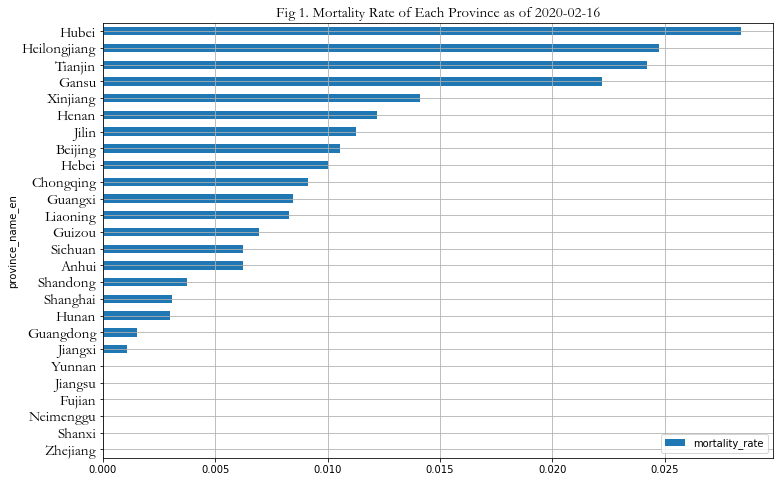

In [0]:
fig = utils.cross_sectional_bar(province.loc[(datetime.date(2020, 2, 16), ), :], 
                                None, col='mortality_rate', groupby='province_name_en', 
                                title='Fig 1. Mortality Rate of Each Province as of 2020-02-16',
                                figsize=(12, 8))
plt.show()

The above plot only shows the rate, but not the "severity".  So try adding the cumulative confirmed cases, and the 7-day trending info

In [0]:
ma = province.reset_index('province_name_en').groupby('province_name_en')['new_confirmed', 'new_dead'].rolling(5, min_periods=1).mean()
# ma from above is indexed by (province, date), which is different order than province's (date, index)
# so direct assignment will result in NA, need to swaplevel first
ma = ma.swaplevel()
province['new_confirmed_MA'] = ma['new_confirmed']
province['new_dead_MA'] = ma['new_dead']

# The next two columns are mainly for plot rendering
province['new_confirmed_logMA'] = np.log10(province['new_confirmed_MA'] + 2)  
province['new_dead_logMA'] = np.log10(province['new_dead_MA'] + 2)

province.loc[(slice(None), 'Hubei'), :].tail()

,,zip_code,cum_confirmed,cum_cured,cum_dead,new_confirmed,new_cured,new_dead,mortality_rate,new_confirmed_MA,new_dead_MA,new_confirmed_logMA,new_dead_logMA
update_date,province_name_en,,,,,,,,,,,,
2020-02-18,Hubei,7187536.0,59989,7943,1789,1807.0,1250.0,93.0,0.029822,2356.6,95.8,3.372654,1.990339
2020-02-19,Hubei,7187536.0,61682,9336,1921,1693.0,1375.0,132.0,0.031144,1939.2,120.6,3.288070,2.088490
2020-02-20,Hubei,7187536.0,62031,10521,2029,349.0,1197.0,108.0,0.032709,1525.0,114.4,3.183839,2.065953
2020-02-21,Hubei,7187536.0,62974,11881,2144,723.0,1348.0,115.0,0.034046,1301.0,109.6,3.114944,2.047664
2020-02-22,Hubei,7187536.0,62662,11881,2144,0.0,0.0,0.0,0.034215,914.4,89.6,2.962085,1.961895


In [0]:
fig = px.scatter(province.loc[(datetime.date(2020, 2, 16), ), :].reset_index(), 
                 x='cum_confirmed', 
                 y='mortality_rate', 
                 size='new_confirmed_logMA', 
                 color='new_dead_logMA',
                 color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name_en', 'cum_dead', 'cum_confirmed', 'new_confirmed_MA', 'new_dead_MA'],
                 title='Mortality Rate vs Confirmed by Province, sized by log(recent 5-day average death count)')
fig.update_layout(xaxis_type="log")
fig.show()

In [0]:
tmp = province.loc[(datetime.date(2020, 2, 20), ), :].reset_index()
tmp = tmp[tmp['province_name_en'] != 'Hubei']
fig2 = px.scatter(tmp, 
                 x='cum_confirmed', 
                 y='mortality_rate', 
                 size='new_confirmed_MA', 
                 color='new_dead_MA',
                 color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name_en', 'cum_dead', 'cum_confirmed', 'new_confirmed_MA', 'new_dead_MA'],
                 title='Mortality Rate vs Confirmed by Province Except Hubei, sized by recent confirm count')
fig2.update_layout(xaxis_type="log")
fig2.show()

In [0]:
py.plot(fig2, filename='mortality_rate_vs_confirm_by_province', auto_copen=True)

'https://plot.ly/~jxu1/111/'

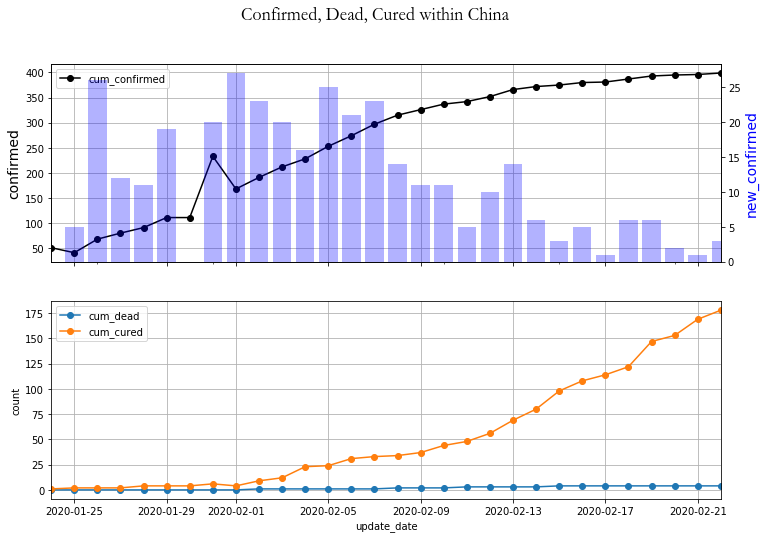

In [0]:
fig = utils.tsplot_conf_dead_cured(daily_frm[daily_frm['province_name'] == '北京市'], title='Confirmed, Dead, Cured within China', figsize=(12, 8))

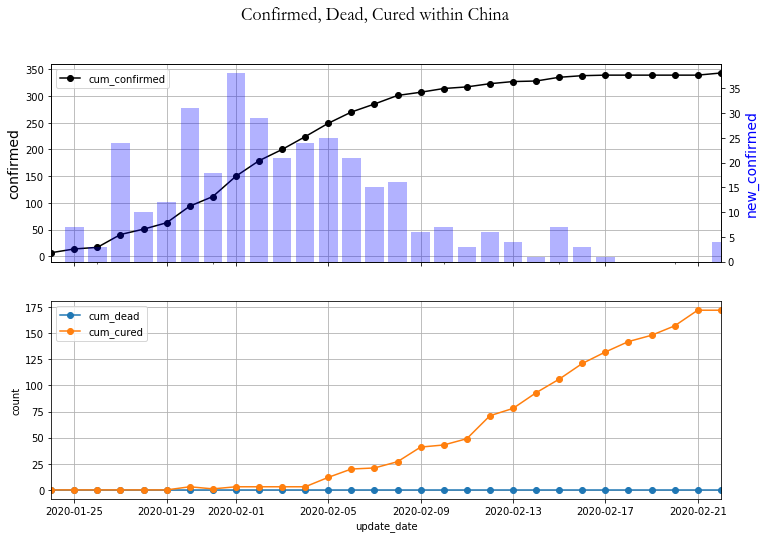

In [0]:
fig = utils.tsplot_conf_dead_cured(daily_frm[daily_frm['city_name'] == '广州'], title='Confirmed, Dead, Cured within China', figsize=(12, 8))

In [0]:
province.loc[(slice(None), 'Beijing'),:].tail()

,,zip_code,cum_confirmed,cum_cured,cum_dead,new_confirmed,new_cured,new_dead,mortality_rate,new_confirmed_MA,new_dead_MA,new_confirmed_logMA,new_dead_logMA
update_date,province_name_en,,,,,,,,,,,,
2020-02-18,Beijing,1651655.0,387,122,4,6.0,8.0,0.0,0.010336,4.2,0.2,0.792392,0.342423
2020-02-19,Beijing,1651655.0,393,147,4,6.0,25.0,0.0,0.010178,4.2,0.2,0.792392,0.342423
2020-02-20,Beijing,1651655.0,395,153,4,2.0,6.0,0.0,0.010127,4.0,0.0,0.778151,0.301030
2020-02-21,Beijing,1651655.0,396,169,4,1.0,16.0,0.0,0.010101,3.2,0.0,0.716003,0.301030
2020-02-22,Beijing,1651655.0,399,178,4,3.0,9.0,0.0,0.010025,3.6,0.0,0.748188,0.301030


# Death rate by city within Hubei

In [0]:
tmp = daily_frm[daily_frm['province_name_en'] == 'Hubei'].copy().set_index(['update_date', 'city_name_en'])
tmp['new_confirmed_MA'] = tmp.reset_index('city_name_en').groupby('city_name_en')['new_confirmed'].rolling(5, min_periods=1).mean().swaplevel()
tmp['mortality_rate'] = tmp['cum_dead'] / tmp['cum_confirmed']
tmp = tmp.reset_index()
tmp_ex_Wuhan = tmp[tmp['city_name_en'] != 'Wuhan']


In [0]:
fig2 = px.scatter(tmp_ex_Wuhan[tmp_ex_Wuhan['update_date'] == pd.to_datetime('2020-02-16')], 
                 x='cum_confirmed', 
                 y='mortality_rate', 
                 size='new_confirmed_MA', 
                 #color='new_dead_MA',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['city_name', 'province_name_en', 'cum_dead', 'cum_confirmed'],
                 title='Mortality Rate vs Confirmed by cities in Hubei (Except Wuhan), sized by recent confirm counts')
fig2.update_layout(xaxis_type="log")
fig2.show()